In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/img_align_celeba.zip' -d GAN

In [3]:
import glob
imgs = glob.glob('/content/GAN/img_align_celeba/*.jpg')

In [4]:
imgs[:5]

['/content/GAN/img_align_celeba/157437.jpg',
 '/content/GAN/img_align_celeba/112315.jpg',
 '/content/GAN/img_align_celeba/162664.jpg',
 '/content/GAN/img_align_celeba/061891.jpg',
 '/content/GAN/img_align_celeba/119758.jpg']

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

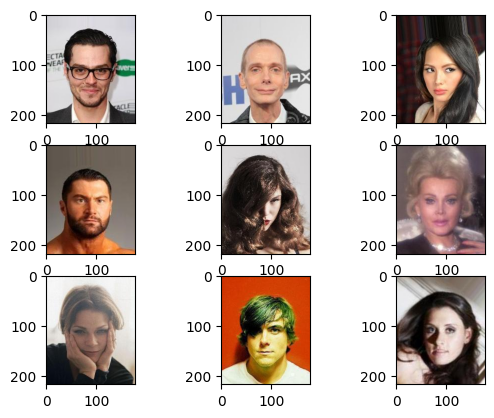

In [6]:
for i in range(9):
  plt.subplot(3,3,i+1)
  img = Image.open(imgs[i+100])
  plt.imshow(img)
plt.show()

In [7]:
import torch
import torchvision.transforms as tf
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

transforms = tf.Compose([
    tf.Resize(64),
    tf.CenterCrop(64),
    tf.ToTensor(),
    tf.Normalize( (0.5, 0.5, 0.5),(0.5, 0.5, 0.5) )
])
dataset = ImageFolder(
    root = './GAN',
    transform=transforms
)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [8]:
data, label = next(iter(loader))

In [9]:
data.shape, label

(torch.Size([128, 3, 64, 64]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]))

In [17]:
import torch.nn as nn
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.gen = nn.Sequential(
        nn.ConvTranspose2d(100,512,kernel_size=4,bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(),

        nn.ConvTranspose2d(512,256,kernel_size=4,bias=False,stride=2,padding=1),
        nn.BatchNorm2d(256),
        nn.ReLU(),

        nn.ConvTranspose2d(256,128,kernel_size=4,bias=False,stride=2,padding=1),
        nn.BatchNorm2d(128),
        nn.ReLU(),

        nn.ConvTranspose2d(128,64,kernel_size=4,bias=False,stride=2,padding=1),
        nn.BatchNorm2d(64),
        nn.ReLU(),

        nn.ConvTranspose2d(64,3,kernel_size=4,bias=False,stride=2,padding=1),
        nn.Tanh()
    )
  def forward(self, x):
    return self.gen(x)

In [18]:
import torch.nn as nn
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.disc = nn.Sequential(
        nn.Conv2d(3,64,kernel_size=4,bias=False,stride=2,padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),

        nn.Conv2d(64,128,kernel_size=4,bias=False,stride=2,padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),

        nn.Conv2d(128,256,kernel_size=4,bias=False,stride=2,padding=1),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2),

        nn.Conv2d(256,512,kernel_size=4,bias=False,stride=2,padding=1),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2),

        nn.Conv2d(512,1,kernel_size=4),
        nn.Sigmoid()
    )
  def forward(self, x):
    return self.disc(x)

In [19]:
data, label = next(iter(loader))
data.shape, label.shape

(torch.Size([128, 3, 64, 64]), torch.Size([128]))

In [20]:
# Discriminator 검증
device = 'cuda' if torch.cuda.is_available() else 'cpu'
D = Discriminator()
data = torch.Tensor(data)

# 입력 데이터를 모델이 사용하는 디바이스로 옮기는 것이 좋습니다.
# 현재 오류 메시지를 보면 입력 데이터의 타입은 torch.cuda.FloatTensor이고,
# 가중치(weight)의 타입은 torch.FloatTensor라고 나와 있습니다.
# 이는 입력 데이터가 GPU에 올라가 있지만, 가중치는 CPU에 있는 것을 의미합니다.
# temp = D(data.to(device))

# 해서 아래와 같은 방법으로 수정하였으나 여전히 같은 에러가 발
data = data.to(device)
temp = D(data)

print(temp.shape)
torch.squeeze( temp).shape

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [21]:
# Generator 검증
sample = torch.randn(label.shape[0], 100,1,1)

In [22]:
G = Generator()
g_sample = G(sample)

In [23]:
g_sample[0].permute(1,2,0).shape

torch.Size([64, 64, 3])

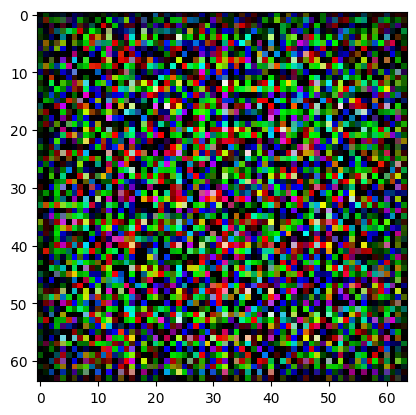

In [24]:
plt.imshow(g_sample[0].permute(1,2,0).detach().numpy())

GAN 원할한 학습을 위해서 가중치를 초기화 하는 함수
  - 합성곱층 가중치 평균0, 표준편차 0.02--> 정규분포
  - 배치정규화 평균 1.0, 표준편차 0.02, 편향은 0
  - 평균이 0 이고 표준편차가 0.02가 되도록 설정-->가장 학습이 잘됨

In [25]:
def weight_init(m):
  # 층의 종류 추출
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

모델 학습

In [26]:
import tqdm
from torch.optim.adam import Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# 생성자
G = Generator().to(device)
G.apply(weight_init)
# 판별자
D = Discriminator().to(device)
D.apply(weight_init)

G_optim = Adam(G.parameters(), lr=0.0001)
D_optim = Adam(D.parameters(), lr=0.0001)

In [27]:
iterator = tqdm.tqdm(enumerate(loader,0), total = len(loader))
i,data = next(iter(iterator))
print(data[0].shape, data[1])

  0%|          | 0/1583 [00:00<?, ?it/s]

torch.Size([128, 3, 64, 64]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [28]:
for epochs in range(1):
  iterator = tqdm.tqdm(loader)
  for data, label_ in iterator:
    D_optim.zero_grad()

    # 정답이미지는 1, 가짜이미지는 0 정답설정
    label = torch.ones_like( label_, dtype=torch.float32).to(device)
    label_fake = torch.zeros_like( label_, dtype=torch.float32).to(device)

    # 실제이미지를 감별자에게 입력
    real = D(data.to(device))  # torch.Size([128, 1, 1, 1])    torch.squeeze(real)  128

    # 실제이미지에 대한 감별자의 오차
    Dloss_real = nn.BCELoss()(torch.squeeze(real), label)
    Dloss_real.backward()

    # 가짜이미지 생성 : 특성공간의 100개 차원의 픽셀 값을 입력
    noise = torch.randn(label.shape[0],100,1,1, device=device)
    fake = G(noise)
    # 가짜이미지를 감별자에 입력
    output =  D(fake.detach())
    # 실제이미지에 대한 감별자의 오차
    Dloss_fake = nn.BCELoss()(torch.squeeze(output), label_fake)
    Dloss_fake.backward()

    # 감별자의 전체 오차
    Dloss = Dloss_real + Dloss_fake
    D_optim.step()

    # 생성자 학습
    G_optim.zero_grad()
    output = D(fake)
    Gloss = nn.BCELoss()(torch.squeeze(output), label)
    Gloss.backward()
    G_optim.step()

    iterator.set_description(f"epoch:{epochs+1} D_loss:{Dloss} G_loss:{Gloss}")

epoch:1 D_loss:0.0316058024764061 G_loss:9.978514671325684: 100%|██████████| 1583/1583 [11:21<00:00,  2.32it/s]


In [32]:
torch.save(G.state_dict(),'/content/drive/MyDrive/Colab Notebooks/Generator.pth')
torch.save(G.state_dict(),'/content/drive/MyDrive/Colab Notebooks/Discriminator.pth')

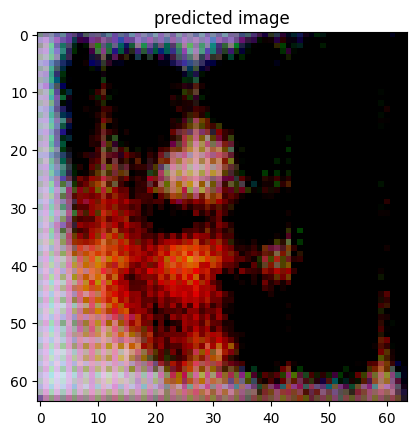

In [33]:
with torch.no_grad():
  # 모델 불러오기
  G_state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/Generator.pth', map_location=device)

  # 모델에 상태 사전 적용
  G.load_state_dict(G_state_dict)

  # 특성 공간의 랜덤한 하나의 점 생성
  feature_vector = torch.randn(1,100,1,1).to(device)

  # 이미지 생성
  pred = G(feature_vector).squeeze()
  pred = pred.permute(1,2,0).cpu().numpy()

  plt.imshow(pred)
  plt.title('predicted image')
  plt.show()